In [1]:
import calendar
import io
import tempfile
import zipfile
from pathlib import Path

import async_retriever as ar
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygeoogc as ogc
import shapely.geometry as sgeom
import utils
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from pygeohydro import NWIS
from scipy import signal

In [2]:
import warnings

warnings.filterwarnings("ignore", message=".*initial implementation of Parquet.*")

In [3]:
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 300, "facecolor": "w"}
BASE_KWDS = {"facecolor": "k", "edgecolor": "b", "alpha": 0.2}
CRS = "esri:102008"

In [4]:
root = Path("..", "data")
out_path = Path(root, "outputs")
img_path = Path(root, "figures")

In [5]:
gulf_east_clip = sgeom.Polygon(
    [
        (-98.0189, 25.6163),
        (-99.0192, 28.2578),
        (-70.0293, 44.8238),
        (-65.9741, 45.6041),
        (-66.4375, 44.5238),
        (-78.9686, 31.6511),
        (-79.75, 24.4402),
        (-83.5973, 24.1171),
        (-91.1961, 28.1507),
        (-96.3344, 25.6423),
        (-98.0189, 25.6163),
    ]
)

east_geo = utils.geo_census(
    "state", sgeom.box(*gulf_east_clip.bounds), "epsg:4326", "east_geo", out_path
).to_crs(CRS)
east_coast = utils.geo_census(
    "coastline", gulf_east_clip, "epsg:4326", "gulf_east_coastline", out_path
).to_crs(CRS)

In [6]:
slope = gpd.read_feather(Path(out_path, "us_coasts_chars.feather"))[["SLOPE___", "geometry"]]
east_slope = slope[slope.within(gulf_east_clip)]

In [7]:
east_states = east_geo[east_geo.intersects(east_coast.buffer(50e3).unary_union)]
urls, kwds = zip(
    *[
        (
            "https://waterservices.usgs.gov/nwis/site/",
            {
                "params": {
                    "format": "rdb",
                    "stateCd": s.lower(),
                    "siteStatus": "all",
                    "siteType": "ST,ST-TS,ES",
                    "outputDataTypeCd": "dv",
                }
            },
        )
        for s in east_states.STUSPS
    ]
)

resp = ar.retrieve(urls, "text", kwds, cache_name=Path(Path.home(), ".cache", "usgs.db"))
data = [r.split("\n") for r in resp if "\n" in r]
data = [[t.split("\t") for t in d if "#" not in t] for d in data]
data = [[dict(zip(d[0], s)) for s in d[2:]] for d in data]
east_stations = pd.concat(pd.DataFrame.from_dict(d).dropna() for d in data)
east_stations["begin_date"] = pd.to_datetime(east_stations["begin_date"])
east_stations["end_date"] = pd.to_datetime(east_stations["end_date"])
east_stations = gpd.GeoDataFrame(
    east_stations,
    geometry=gpd.points_from_xy(east_stations.dec_long_va, east_stations.dec_lat_va),
    crs="epsg:4326",
)
east_stations.to_feather(Path(out_path, "gulf_east_usgs_stations.feather"))

In [8]:
def set_legend(parm_cd: str, stat_cd: str, end_date: pd.Timestamp) -> str:
    if parm_cd == "00060" and stat_cd == "00003" and end_date > pd.to_datetime("2000-01-01"):
        return "Available"
    return "N/A"

In [9]:
east_tidal = gpd.read_feather(Path(out_path, "gulf_east_usgs_stations.feather"))
east_tidal = east_tidal[east_tidal.site_tp_cd.isin(["ST-TS", "ES"])]
east_tidal["legend"] = [
    set_legend(p, s, e)
    for p, s, e in east_tidal[["parm_cd", "stat_cd", "end_date"]].itertuples(index=False, name=None)
]

In [10]:
nwis = NWIS()
stations = list(set(east_tidal[east_tidal["legend"] == "Available"].site_no.unique()))
discharge = nwis.get_streamflow(
    stations,
    ("2000-01-01", "2015-12-31"),
)
discharge[discharge < 0] = np.nan
discharge.to_parquet(Path(out_path, "discharge.paquet"))

Dropped 0 stations since they don't have daily mean discharge from 2000-01-01 to 2015-12-31.


In [11]:
discharge = pd.read_parquet(Path(out_path, "discharge.paquet"))
stats = discharge.describe()
m_mean, m_max = stats.loc["mean"].mean(), stats.loc["max"].mean()

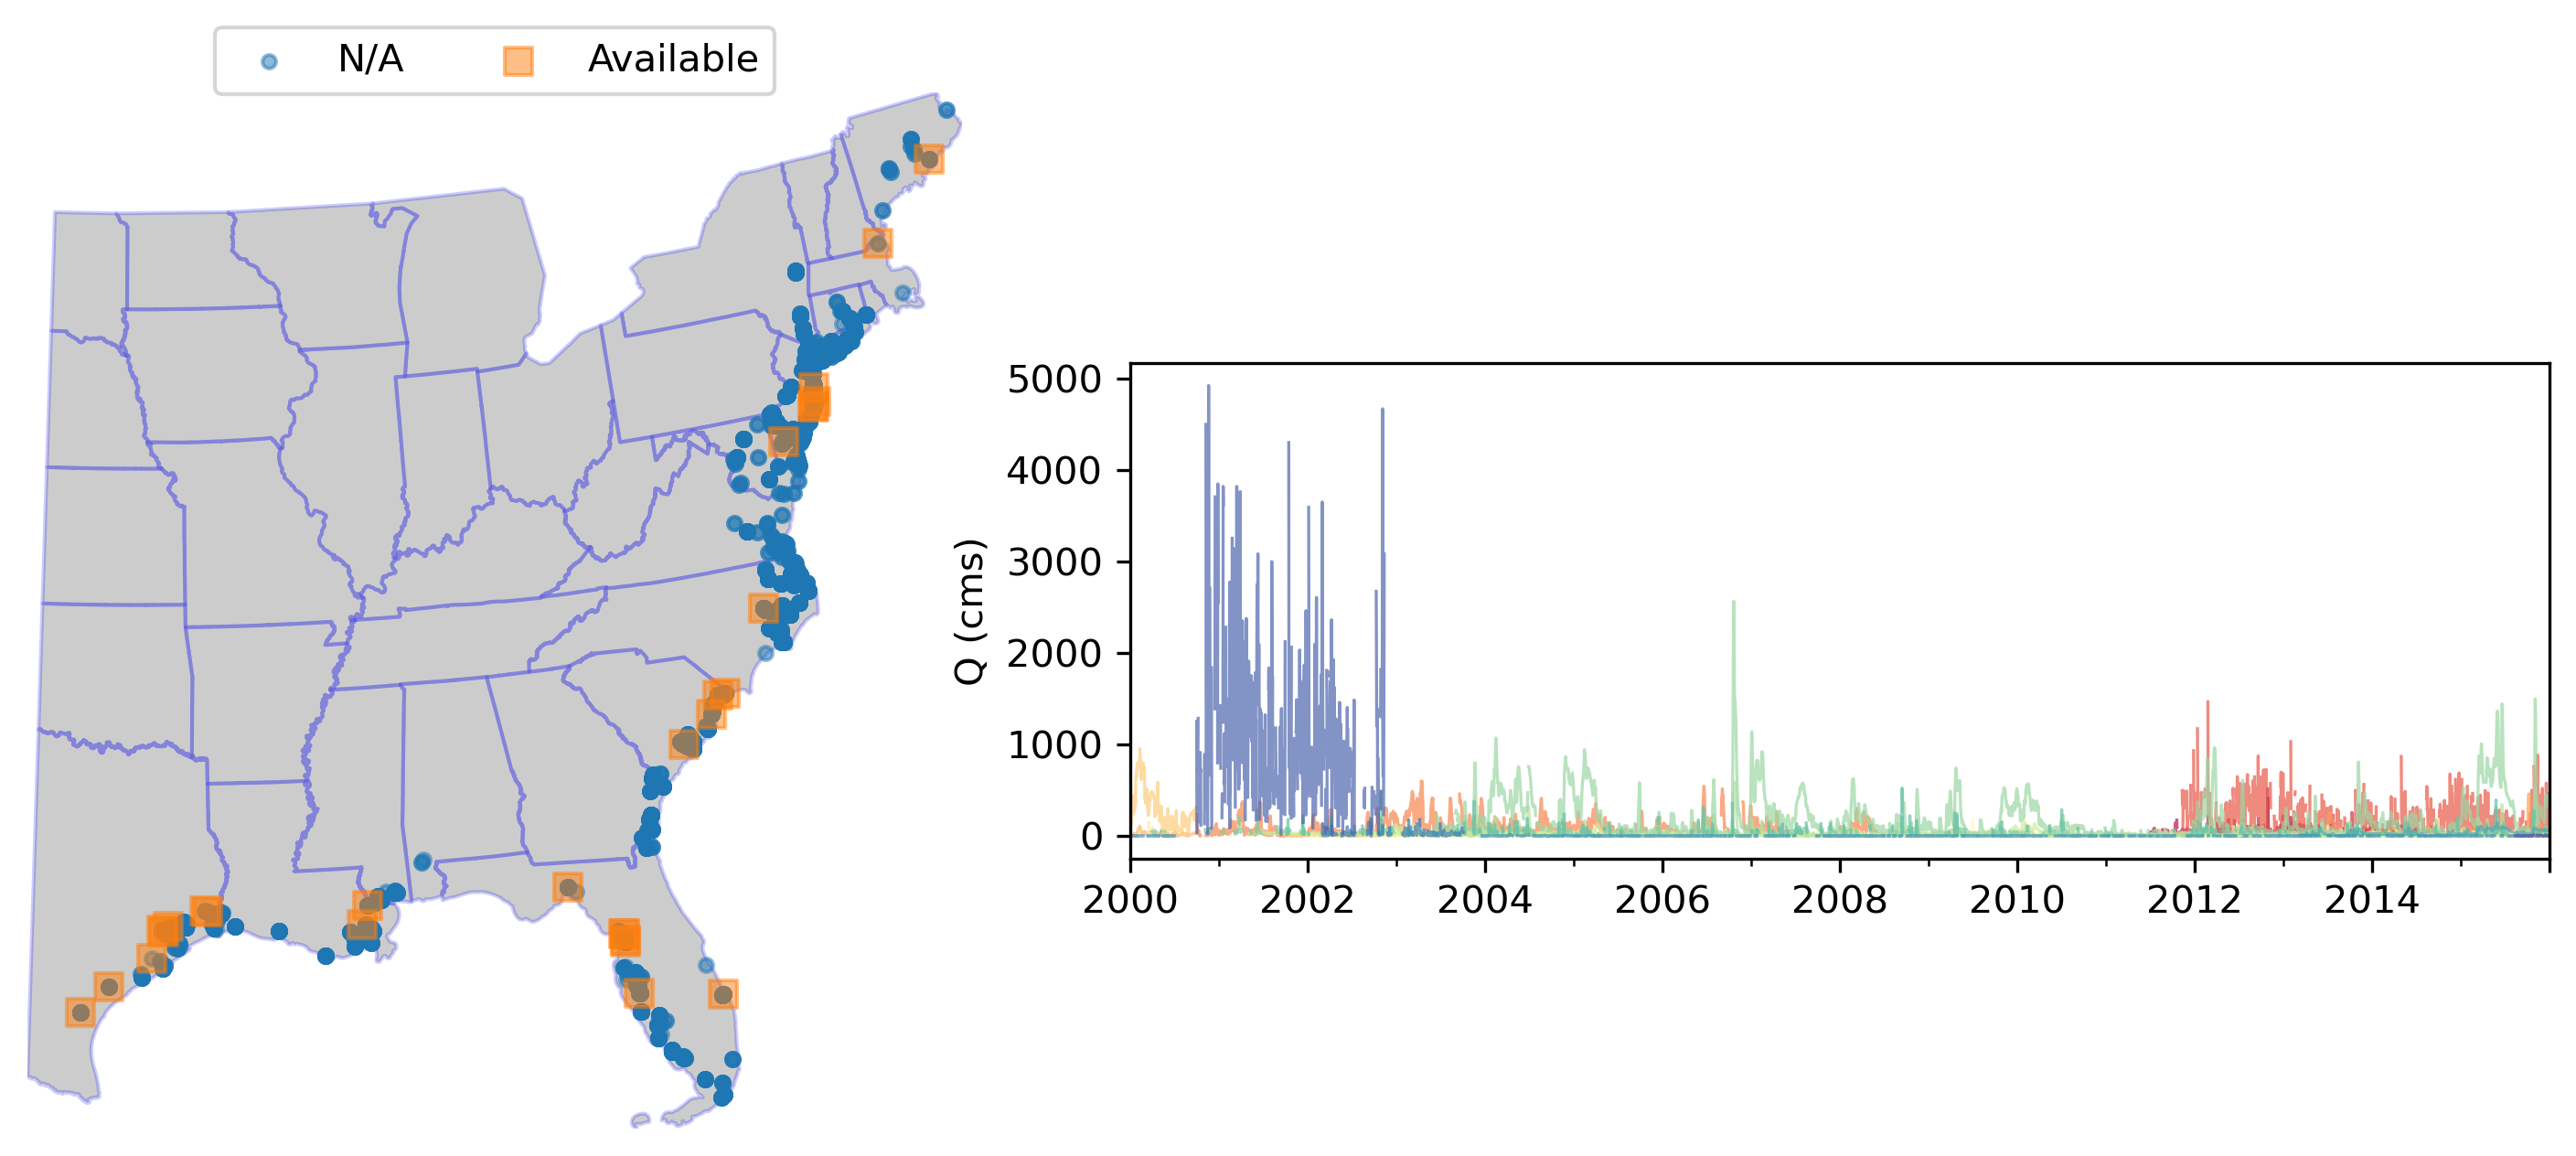

In [12]:
fig = plt.figure(figsize=(13, 5), dpi=300)

gs = GridSpec(4, 4, figure=fig, wspace=-0.1)
ax1 = fig.add_subplot(gs[:, :2])
ax2 = fig.add_subplot(gs[1:3, 2:])

et = east_tidal.to_crs(CRS)
east_geo.plot(ax=ax1, **BASE_KWDS)
for leg, (m, c) in zip(et.legend.unique(), zip(Line2D.markers, mcolors.TABLEAU_COLORS)):
    et[et.legend == leg].plot(
        ax=ax1,
        color=c,
        marker=m,
        alpha=0.5,
        markersize=50,
        label=leg,
    )
ax1.axis("off")
ax1.margins(0)
ax1.legend(loc="lower center", bbox_to_anchor=(0.5, 0.98), ncol=2)

discharge.plot(ax=ax2, legend=False, cmap="Spectral", alpha=0.7, lw=0.8)
ax2.set_ylabel("Q (cms)")
ax2.set_xlabel("")
fig.savefig(Path(img_path, "usgs_discahrge.png"), **SAVE_KWDS)

In [13]:
resp = ogc.RetrySession().get("https://pubs.usgs.gov/dds/dds68/data/cvi.zip")

with zipfile.ZipFile(io.BytesIO(resp.content)) as zfile:
    with tempfile.TemporaryDirectory() as d:
        zfile.extractall(d)
        cvi_list = []
        for f in Path(d, "CVI").glob("*"):
            cvi_list.append(gpd.read_file(f"{f}/{f.stem}.shp"))
        cvi_df = gpd.GeoDataFrame(pd.concat(cvi_list))
        cvi_df = cvi_df.set_crs("epsg:4326")
        cols = ["TIDE_M_", "SLOPE___", "ERR_M_YR_", "SL_MM_YR_", "WAVES_M_", "geometry"]
        cvi_df[cols].to_feather(Path(out_path, "us_coasts_chars.feather"))

In [14]:
slope = gpd.read_feather(Path(out_path, "us_coasts_chars.feather"))[["SLOPE___", "geometry"]]
east_slope = slope[slope.within(gulf_east_clip)]

In [15]:
url = "https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/product.json"
r = ogc.RetrySession().get(url, payload={"name": "extremewaterlevels", "units": "metric"})

ext_wl = pd.DataFrame.from_dict(r.json()["ExtremeWaterLevels"])
ext_wl = gpd.GeoDataFrame(
    ext_wl,
    geometry=gpd.points_from_xy(ext_wl.longitude, ext_wl.latitude),
    crs="epsg:4326",
)
east_ext = ext_wl[ext_wl.within(gulf_east_clip)].to_crs(CRS)
east_ext.to_feather(Path(out_path, "extreme_wl.feather"))

In [16]:
east_ext = gpd.read_feather(Path(out_path, "extreme_wl.feather"))
ext_vars = {
    "f1_gtmhhw": "1% exceedance probability above MHHW",
    "f1_ltmllw": "1% exceedance probability below MLLW",
    "f10_gtmhhw": "10% exceedance probability above MHHW",
    "f10_ltmllw": "10% exceedance probability below MLLW",
    "f50_gtmhhw": "50% exceedance probability above MHHW",
    "f50_ltmllw": "50% exceedance probability below MLLW",
    "f99_gtmhhw": "99% exceedance probability above MHHW",
    "f99_ltmllw": "99% exceedance probability below MLLW",
}

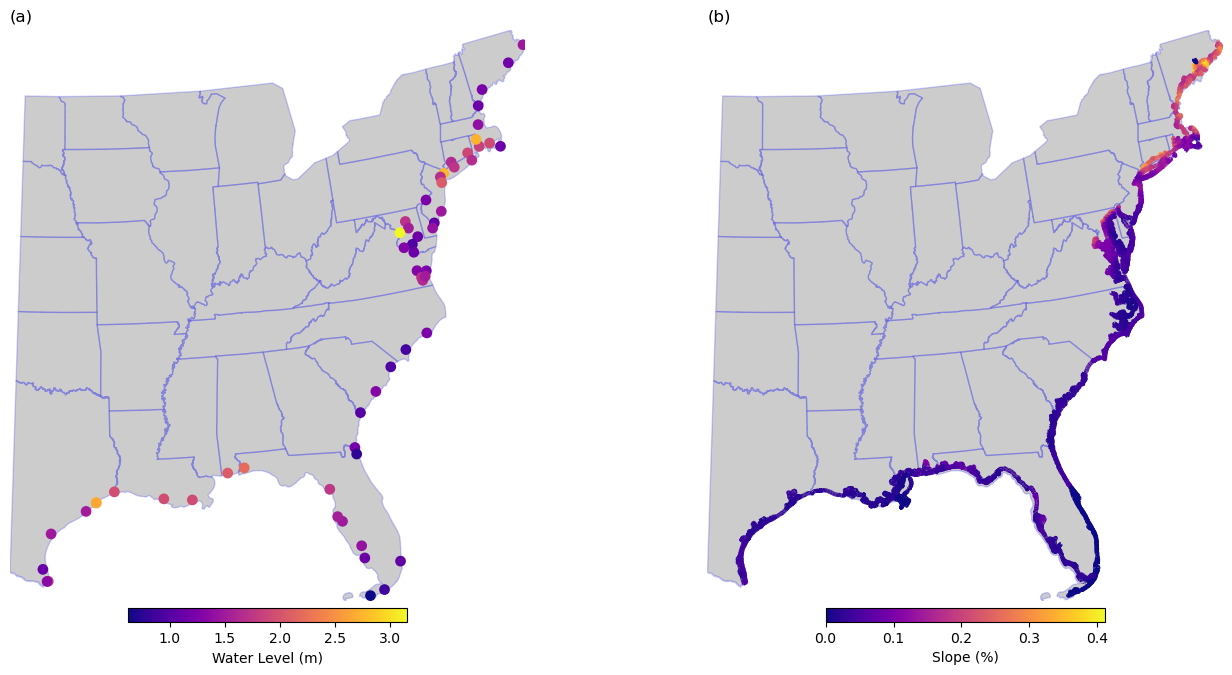

In [17]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(18, 9), dpi=100, gridspec_kw={"wspace": 0})
east_geo.plot(ax=ax1, **BASE_KWDS)
east_slope.to_crs(east_geo.crs).plot(
    ax=ax1,
    lw=3,
    column="SLOPE___",
    cmap="plasma",
    legend=True,
    legend_kwds={
        "label": "Slope (%)",
        "orientation": "horizontal",
        "shrink": 0.4,
        "pad": 0.01,
    },
)
ax1.axis("off")
ax1.set_title("(b)", loc="left")
ax1.margins(0)

col = "f1_gtmhhw"
east_geo.plot(ax=ax2, **BASE_KWDS)
east_ext.plot(
    ax=ax2,
    column=col,
    markersize=45,
    cmap="plasma",
    legend=True,
    legend_kwds={
        "label": "Water Level (m)",
        "orientation": "horizontal",
        "shrink": 0.4,
        "pad": 0.01,
    },
)
ax2.axis("off")
ax2.set_title("(a)", loc="left")
ax2.margins(0)
fig.savefig(Path(img_path, "slope_extreme_wl.png"), **SAVE_KWDS)

In [18]:
url = "https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations.json"
payload = {"type": "waterlevels", "expand": "details"}
r = ogc.RetrySession().get(url, payload=payload)
rjson = r.json()

sts = pd.DataFrame.from_dict(rjson["stations"])
sts["established"] = sts.details.apply(lambda x: x["established"])
sts = sts[
    [
        "id",
        "name",
        "lat",
        "lng",
        "state",
        "established",
        "tidal",
        "greatlakes",
        "stormsurge",
    ]
]
stations = gpd.GeoDataFrame(sts, geometry=gpd.points_from_xy(sts.lng, sts.lat), crs="epsg:4326")

stations.to_feather(Path(out_path, "gulf_east_wl_stations.feather"))

In [19]:
stations = gpd.read_feather(Path(out_path, "gulf_east_wl_stations.feather")).set_index("id")
eg_stations = stations[(stations.within(gulf_east_clip)) & (stations.established < "2000-01-01")]

In [20]:
base_url = "https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations"
urls = [f"{base_url}/{i}/harcon.json?units=metric" for i in eg_stations.index]
resp = ar.retrieve(urls, "json", cache_name=Path(Path.home(), ".cache", "noaa.db"))

con_list = []
str_list = []
missing_con = []
for rjson in resp:
    try:
        sid = rjson["self"].rsplit("/", 2)[1]
        const = pd.DataFrame.from_dict(rjson["HarmonicConstituents"])
        const = const.drop(columns="number").set_index("name")
        const.attrs = {"id": sid, "units": rjson["units"]}
        con_list.append(const)
        argmax = const.amplitude.argmax()
        str_list.append((sid, const.index[argmax], const.iloc[argmax]["amplitude"]))
    except KeyError:
        missing_con.append(sid)

keys = [c.attrs["id"] for c in con_list]
tide_con = pd.concat((c.T.drop("description") for c in con_list), keys=keys)

tide_con.attrs = con_list[0].description.to_dict()

strongest = pd.DataFrame(str_list)
strongest.columns = ["id", "Constituent", "Amplitude"]
strongest = gpd.GeoDataFrame(pd.merge(eg_stations, strongest, on="id"))

con_list[0].description.to_csv(Path(out_path, "tidal_constituents_desc.csv"))
tide_con.to_parquet(Path(out_path, "tidal_constituents.parquet"))
strongest.to_feather(Path(out_path, "strongest_tidal_constituents.feather"))

In [21]:
tide_con = pd.read_parquet(Path(out_path, "tidal_constituents.parquet"))
strongest = gpd.read_feather(Path(out_path, "strongest_tidal_constituents.feather"))

In [22]:
start = pd.to_datetime("2000-01-01")
end = pd.to_datetime("2015-12-31")
url = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"

urls, kwds = zip(
    *[
        (
            url,
            {
                "params": {
                    "product": "monthly_mean",
                    "application": "NOS.COOPS.TAC.WL",
                    "begin_date": f'{start.strftime("%Y%m%d")}',
                    "end_date": f'{end.strftime("%Y%m%d")}',
                    "datum": "MSL",
                    "station": f"{sid}",
                    "time_zone": "GMT",
                    "units": "metric",
                    "format": "json",
                }
            },
        )
        for sid in eg_stations.index
    ]
)

resp = ar.retrieve(
    urls,
    read="json",
    request_kwds=kwds,
    cache_name=Path(Path.home(), ".cache", "noaa.db"),
)
mm_list = []
missing_mms = []
for rjson in resp:
    try:
        mm = pd.DataFrame.from_dict(rjson["data"])
        mm = mm.apply(pd.to_numeric, errors="coerce")
        mm.attrs = rjson["metadata"]
        mm_list.append(mm)
    except KeyError:
        missing_mms.append(mm.attrs["id"])

keys = [c.attrs["id"] for c in mm_list]
mean_monthly = pd.concat((c.set_index(["year", "month"]) for c in mm_list), keys=keys)
mean_monthly.index = mean_monthly.index.rename(("id", "year", "month"))
mean_monthly.to_parquet(Path(out_path, "mean_monthly.parquet"))

In [23]:
mean_monthly = pd.read_parquet(Path(out_path, "mean_monthly.parquet"))

seasonal = mean_monthly.groupby(level=[0, 2]).mean()
mn = seasonal.reset_index().pivot(index="month", columns="id", values="MN")
mn.index = mn.reset_index().month.apply(lambda x: calendar.month_abbr[x])
demeaned = mn - mn.mean()

strg_grp = demeaned.T.merge(
    strongest.set_index("id").Constituent, left_index=True, right_index=True
).groupby("Constituent")

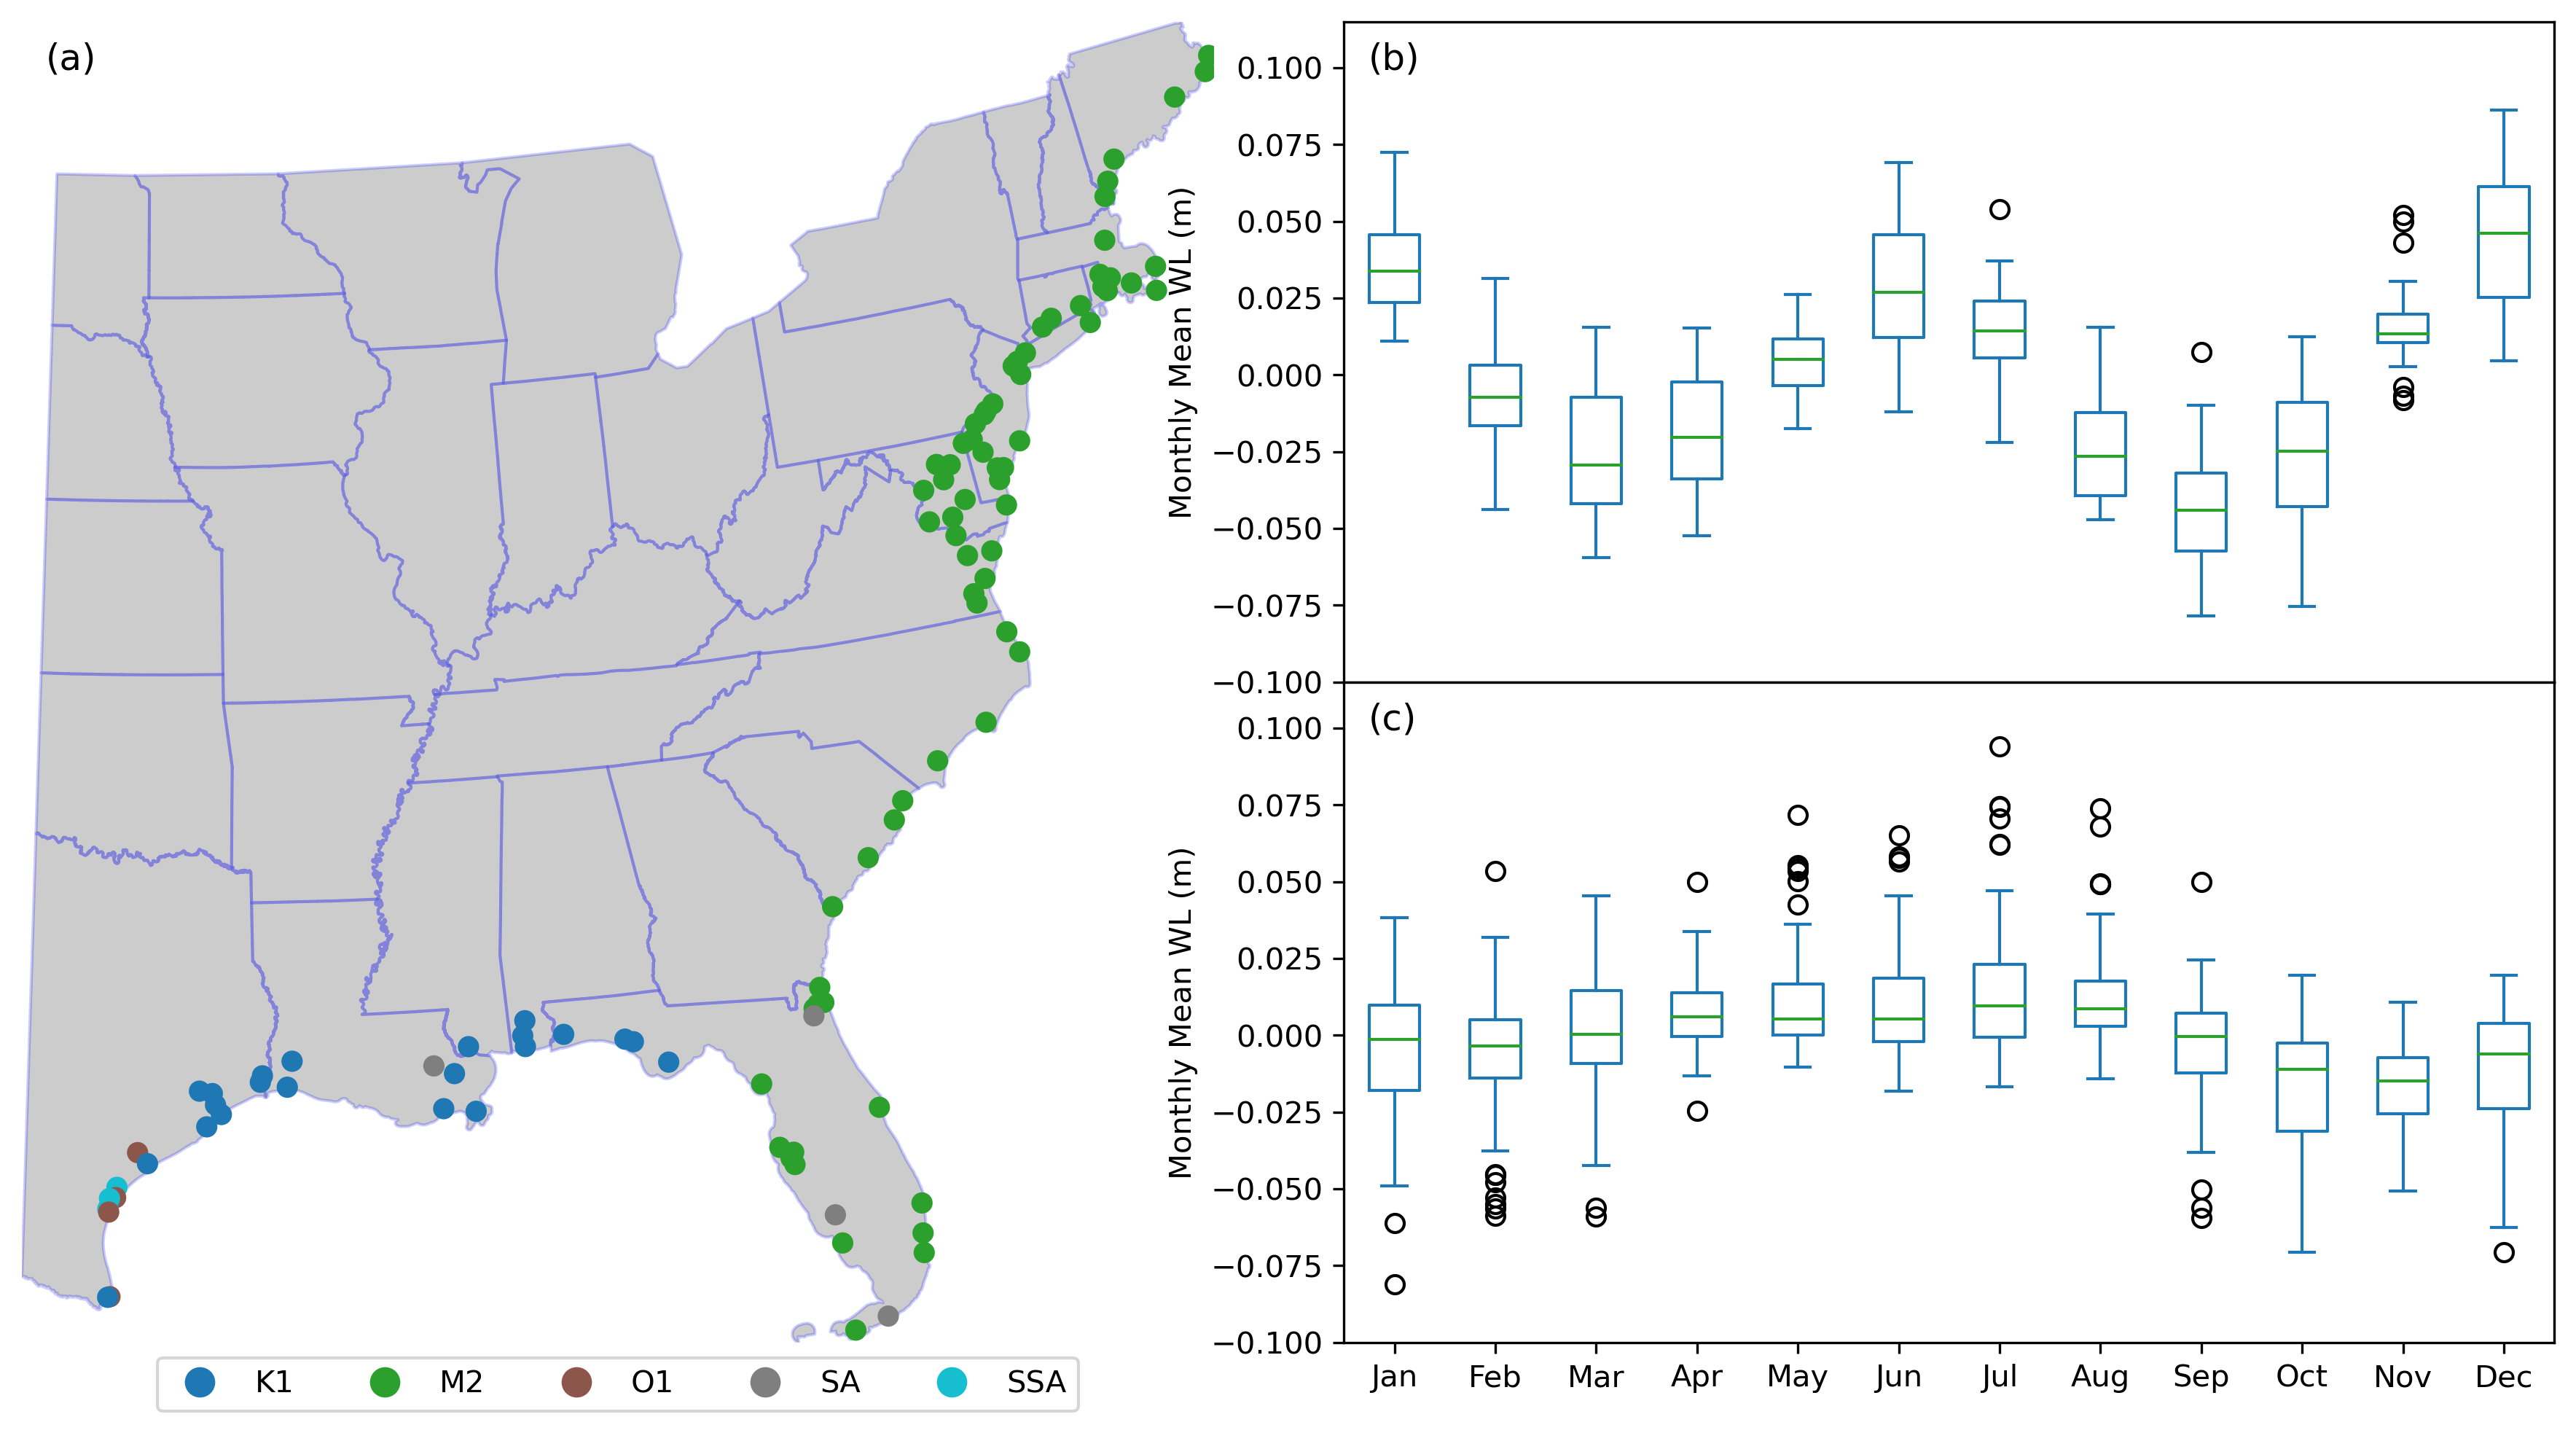

In [24]:
fig = plt.figure(figsize=(15, 8), dpi=300)

gs = GridSpec(2, 2, figure=fig, wspace=0.1)
ax1 = fig.add_subplot(gs[:, 0])
axes = [fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 1])]

east_geo.plot(ax=ax1, **BASE_KWDS)
strongest.to_crs(CRS).plot(
    ax=ax1,
    column="Constituent",
    legend=True,
    legend_kwds={"loc": "upper center", "ncol": 5, "bbox_to_anchor": (0.5, 0)},
)
ax1.axis("off")
ax1.margins(0)
ax1.set_title("(a)", loc="left", y=0.95, x=0.02)

enum = ["(b)", "(c)"]
for i, n in enumerate(["K1", "M2"]):
    grp = strg_grp.get_group(n)
    grp.drop(columns="Constituent").plot.box(ax=axes[i], sharex=True, legend=False)
    axes[i].set_title(enum[i], loc="left", y=0.9, x=0.02)
    axes[i].set_ylim(-0.1, 0.115)
    axes[i].margins(0)
    axes[i].set_ylabel("Monthly Mean WL (m)")
plt.subplots_adjust(
    hspace=0,
)
fig.savefig(Path(img_path, "tidal_constituents.png"), **SAVE_KWDS)

## Atlantic City, NJ

In [25]:
station_id = "8534720"
start, end = pd.to_datetime("2012-10-10"), pd.to_datetime("2012-11-10")

In [26]:
url = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"
payload = {
    "product": "predictions",
    "application": "web_services",
    "begin_date": f'{start.strftime("%Y%m%d")}',
    "end_date": f'{end.strftime("%Y%m%d")}',
    "datum": "MSL",
    "station": f"{station_id}",
    "time_zone": "GMT",
    "units": "metric",
    "format": "json",
}

rjson = ogc.RetrySession().get(url, payload=payload).json()

water_level = pd.DataFrame.from_dict(rjson["predictions"])
water_level["t"] = pd.to_datetime(water_level.t)
water_level = water_level.set_index(water_level.t).drop(columns="t")
water_level["v"] = pd.to_numeric(water_level.v, errors="coerce")
water_level.to_parquet(Path(out_path, "water_level_atlantic.parquet"))

In [27]:
def triangular_surge(wl_df, start, peak, end, wl_col, surge_height):
    wl = wl_df.copy()

    tt = wl.reset_index().t
    s_idx = tt[tt == start].index[0]
    p_idx = tt[tt == peak].index[0]
    e_idx = tt[tt == end].index[0]
    tt = tt - tt[0]
    tt = tt.dt.total_seconds()

    rise = np.interp(tt[s_idx:p_idx], [tt[s_idx], tt[p_idx - 1]], [0, surge_height])
    fall = np.interp(tt[p_idx : e_idx + 1], [tt[p_idx], tt[e_idx]], [surge_height, 0])
    pulse = np.concatenate([rise, fall])

    wl["surge"] = wl[wl_col]
    wl.loc[start:end, "surge"] = wl.loc[start:end, wl_col] + pulse
    return wl


def dflow_format(wl, t_col, wl_col, fname):
    wl_out = wl.reset_index()
    dt = wl_out[t_col] - wl_out[t_col].iloc[0]
    wl_out[t_col] = dt.dt.total_seconds()
    wl_out[[t_col, wl_col]].to_csv(fname, header=False, index=False, sep=" ")

In [28]:
sim_start = pd.to_datetime("2012-10-10 00:00:00")
sh_min, sh_max = east_ext[col].min(), east_ext[col].max()
water_level = pd.read_parquet(Path(out_path, "water_level_atlantic.parquet"))
water_level["v"] = signal.detrend(water_level.v, type="constant")
start, end = "2012-10-29 00:00:00", "2012-11-02 23:00:00"
peak = "2012-10-31 12:00:00"

wl_min = triangular_surge(water_level, start, peak, end, "v", sh_min)
dflow_format(wl_min, "t", "surge", Path(out_path, "surge_min.csv"))

wl_max = triangular_surge(water_level, start, peak, end, "v", sh_max)
dflow_format(wl_max, "t", "surge", Path(out_path, "surge_max.csv"))

dflow_format(wl_min, "t", "v", Path(out_path, "no_surge.csv"))

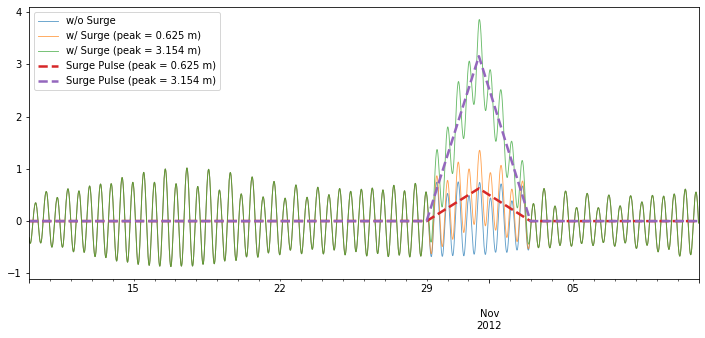

In [29]:
wl_min.columns = ["w/o Surge", f"w/ Surge (peak = {sh_min} m)"]
wl_max.columns = ["w/o Surge", f"w/ Surge (peak = {sh_max} m)"]
ax = wl_min.plot(figsize=(12, 5), lw=0.9, alpha=0.7)
wl_max[f"w/ Surge (peak = {sh_max} m)"].plot(lw=0.9, alpha=0.7)

(wl_min[f"w/ Surge (peak = {sh_min} m)"] - wl_min["w/o Surge"]).plot(
    ls="--", label=f"Surge Pulse (peak = {sh_min} m)", lw=2.5
)
(wl_max[f"w/ Surge (peak = {sh_max} m)"] - wl_max["w/o Surge"]).plot(
    ls="--", label=f"Surge Pulse (peak = {sh_max} m)", lw=2.5
)
ax.legend(loc="upper left")
ax.set_xlabel("")
ax.figure.savefig(Path(img_path, "water_level_surge.png"), **SAVE_KWDS)